### Import libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')

from datetime import datetime, timedelta

# Import utils functions
## Import function to generate Geometric Brownian Motion with seasonality
from utils.monte_carlo_utils import get_gbm_with_seasonality_paths, get_stocks_universe
## Import function to generate different clusters for data
from utils.data_gen_utils import generate_clusters_dict, get_sectors_df
## Import plotting function to show different stock typs
from utils.plot_utils import plot_data_sample
## Import Preprocessing function to get MinMax scaled values
from utils.preprocessing_utils import get_min_max_scaled_values
## Import DTW function to generate DTW Similarity Matrix
from utils.dtw_utils import get_dtw_matrix, get_l_n_distance
## Import Calculations utility functions
from utils.calc_utils import get_time
from utils.k_medoids_utils import get_coocurrence_matrix, get_optimal_clusters_plot, get_coocurrence_matrix_plot, get_sectors

### General Idea

This notebook shows the first attempt to approach heterogeneous time-series analysis, which was inspired by the following article

**Authors:**
- Lukas Neubauer
- Peter Filzmoser

[Improving Forecasts for Heterogeneous Time Series by ”Averaging”, with Application to Food Demand Forecast](https://arxiv.org/pdf/2306.07119.pdf)

Authors describe heterogeneous time-series as a set of time-series data where each series may have different properties such as length, shape, or seasonality which can make them challenging to model in a unified manner​.

The article proposes a framework for improving forecasts of heterogeneous time-series by leveraging Dynamic Time Warping (DTW) to find similar time series and averaging forecasts, especially useful for time-series which do not have long sample of data. The approach constructs neighborhoods of similar time series, allowing for better one-step ahead forecasts through averaging techniques. 

### Problem Proposal

We can take a step in the direction proposed by authors and try to solve the following problem: given little information about stocks, described by time-series with different properties, is it possible  to use methods such as DTW and Clustering to imply any information from prices?

As an idea, we can use these methods to clusters of stock which would represent different sectors/industries.

### Solution

Let's try to approach this problem, using simulated data

#### Generate Time-Series

For a sake of example, we will stick to time-series of the same length, but exhibiting different shape and seasonality. 

To approach this, let's make a twist on standard Geometric Brownian Motion (GBM) approach. We will generate Geometric Brownian Motion with additional sin-like function for time trend.  

The SDE for this process looks the following way:

$$dS_t = (\mu + \alpha_t) S_t dt + \sigma dW_t$$
$$\alpha_t = \sin(2\pi \times t \times \alpha)$$

The Euler-Maruyama discretization to generate process paths is

$$ S_t = S_{t-1} (1 + \mu + \alpha_{t-1})dt + \sigma \sqrt{t} \mathcal{N}(0, 1)$$

Let's generate data for this process and look at stock price trajectories

In [3]:
clusters_dict = generate_clusters_dict()
clusters_params_df = pd.DataFrame(clusters_dict).T

In [4]:
print(f'{clusters_params_df.shape[0]} Clusters Overall')
clusters_params_df.head()

27 Clusters Overall


,cluster_id,mu,sigma,alpha
low_ret_low_vol_slow_season,0.0,0.05,0.1,0.5
low_ret_low_vol_med_season,1.0,0.05,0.1,1.0
low_ret_low_vol_fast_season,2.0,0.05,0.1,1.5
low_ret_med_vol_slow_season,3.0,0.05,0.2,0.5
low_ret_med_vol_med_season,4.0,0.05,0.2,1.0


We see that there is a drastic difference between stocks with low/medium/high volatility (vertical axis) and between stocks with slow/medium/fast seasonality (different linear charts on the same subplot).

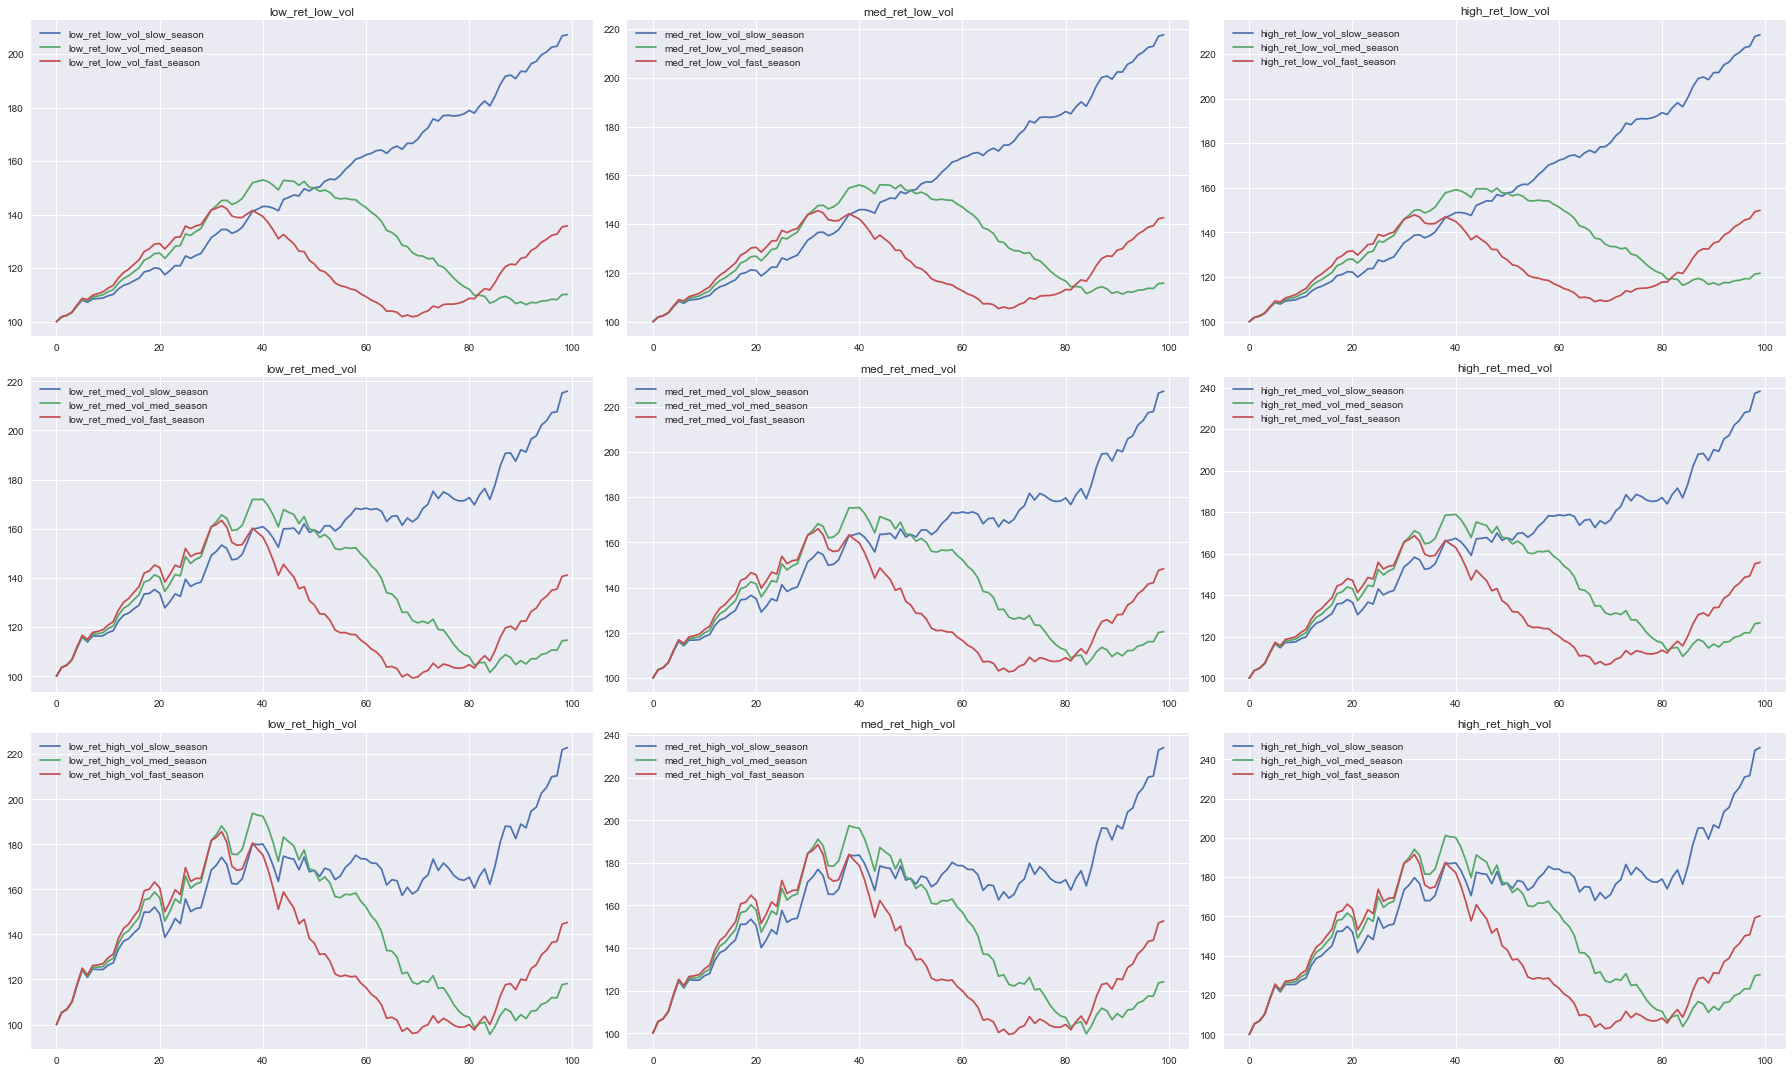

In [5]:
plot_data_sample(clusters_dict=clusters_dict)

Now, let's generate 10 stocks for each sector to construct our investing universe. 

We will sample data during 1 year by 5-min intervals for each trading session, assuming that the there is 252 trading days per year, 6h trading session and 12 5-min periods per hour.

In [6]:
df = get_stocks_universe(clusters_dict=clusters_dict,
                         stocks_per_cluster=10,
                         T=1, n_steps=252 * 6 * 12)

In [7]:
df.head()

stock_id,0,1,2,3,4,5,6,7,8,9,...,260,261,262,263,264,265,266,267,268,269
time,,,,,,,,,,,,,,,,,,,,,
0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
1,100.131237,100.131237,100.131237,100.131237,100.131237,100.131237,100.131237,100.131237,100.131237,100.131237,...,100.393712,100.393712,100.393712,100.393712,100.393712,100.393712,100.393712,100.393712,100.393712,100.393712
2,100.161261,100.161261,100.161261,100.161261,100.161261,100.161261,100.161261,100.161261,100.161261,100.161261,...,100.484018,100.484018,100.484018,100.484018,100.484018,100.484018,100.484018,100.484018,100.484018,100.484018
3,100.234317,100.234317,100.234317,100.234317,100.234317,100.234317,100.234317,100.234317,100.234317,100.234317,...,100.703892,100.703892,100.703892,100.703892,100.703892,100.703892,100.703892,100.703892,100.703892,100.703892
4,100.401348,100.401348,100.401348,100.401348,100.401348,100.401348,100.401348,100.401348,100.401348,100.401348,...,101.207333,101.207333,101.207333,101.207333,101.207333,101.207333,101.207333,101.207333,101.207333,101.207333


We labeled stocks the way that 10 stock_ids represent the same cluster, so we see that stocks 0-2 statistics differ a lot from stocks 267-269. Nevertheless, we do not pass this information further and assume that we only observe stock prices.

Let's take a look at returns

In [8]:
df_rets = df.pct_change().dropna()

df_rets.describe().iloc[:, [0, 1, 2, 267, 268, 269]]

stock_id,0,1,2,267,268,269
count,18143.000000,18143.000000,18143.000000,18143.000000,18143.000000,18143.000000
mean,0.000034,0.000034,0.000034,0.000007,0.000007,0.000007
std,0.000735,0.000735,0.000735,0.002206,0.002206,0.002206
min,-0.002741,-0.002741,-0.002741,-0.008270,-0.008270,-0.008270
25%,-0.000462,-0.000462,-0.000462,-0.001483,-0.001483,-0.001483
50%,0.000027,0.000027,0.000027,-0.000011,-0.000011,-0.000011
75%,0.000528,0.000528,0.000528,0.001493,0.001493,0.001493
max,0.002853,0.002853,0.002853,0.008530,0.008530,0.008530


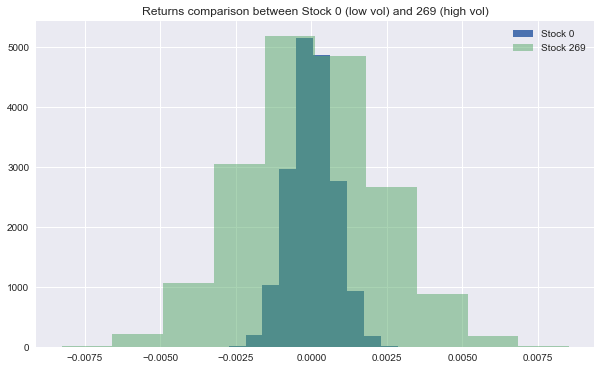

In [9]:
plt.figure(figsize=(10, 6))
plt.hist(df_rets[0], label='Stock 0')
plt.hist(df_rets[269], alpha=0.5, label='Stock 269')
plt.legend()
plt.title('Returns comparison between Stock 0 (low vol) and 269 (high vol)')
plt.show()

Now, we will use this data to construct DTW matrix of similarities.

#### Dynamic Time-Warping

Dynamic Time Warping originated in the field of speech recognition in the 70s. 

The idea addresses the issue of temporal matching between different data patterns. Traditional Euclidean distance or cosine similarity measures between two time-series may be inadequate when the sequences are out-of-sync temporally. DTW allows to optimally align two time-series sequences by "warping" the time dimension in a way that minimizes a certain cost function, e.g. the Euclidean distance.

$$
DTW(i, j) = d(a_i, b_j) +\min\{DTW(i-1, j), DTW(i, j-1), DTW(i-1, j-1)\} $$

$$ d(a_i, b_j) = (a_i - b_j)^2 $$

With Boundary Conditions

$$ DTW(0, j) = \infty, \quad DTW(i, 0) = \infty, \quad DTW(0, 0) = 0 $$

We would use Min-Max scaling for returns data, as it could make the results easier to interpret and compare. For instance, the DTW distance will be easier to understand relative to the scaled data.

As our data comes from known distribution, sensitivity of Min-Max scaling to outliers shoudn't be a problem. Nevertheless, we should be more cautions when work with real data, as a single extreme value can distort the scale for the entire series.

In [10]:
df_rets_scaled = get_min_max_scaled_values(df_rets)

In [11]:
df_rets_scaled.describe()

stock_id,0,1,2,3,4,5,6,7,8,9,...,260,261,262,263,264,265,266,267,268,269
count,18143.000000,18143.000000,18143.000000,18143.000000,18143.000000,18143.000000,18143.000000,18143.000000,18143.000000,18143.000000,...,18143.000000,18143.000000,18143.000000,18143.000000,18143.000000,18143.000000,18143.000000,18143.000000,18143.000000,18143.000000
mean,0.495914,0.495914,0.495914,0.495914,0.495914,0.495914,0.495914,0.495914,0.495914,0.495914,...,0.492693,0.492693,0.492693,0.492693,0.492693,0.492693,0.492693,0.492693,0.492693,0.492693
std,0.131440,0.131440,0.131440,0.131440,0.131440,0.131440,0.131440,0.131440,0.131440,0.131440,...,0.131312,0.131312,0.131312,0.131312,0.131312,0.131312,0.131312,0.131312,0.131312,0.131312
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.407346,0.407346,0.407346,0.407346,0.407346,0.407346,0.407346,0.407346,0.407346,0.407346,...,0.403976,0.403976,0.403976,0.403976,0.403976,0.403976,0.403976,0.403976,0.403976,0.403976
50%,0.494815,0.494815,0.494815,0.494815,0.494815,0.494815,0.494815,0.494815,0.494815,0.494815,...,0.491622,0.491622,0.491622,0.491622,0.491622,0.491622,0.491622,0.491622,0.491622,0.491622
75%,0.584286,0.584286,0.584286,0.584286,0.584286,0.584286,0.584286,0.584286,0.584286,0.584286,...,0.581139,0.581139,0.581139,0.581139,0.581139,0.581139,0.581139,0.581139,0.581139,0.581139
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


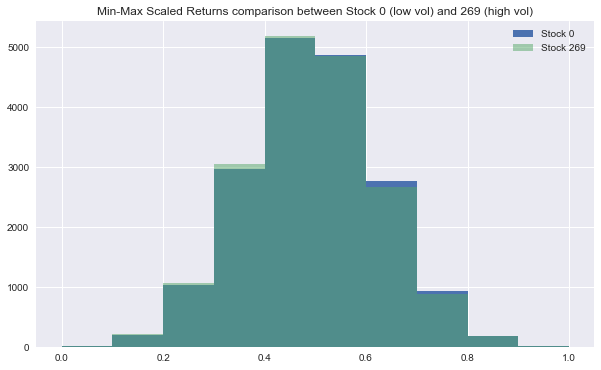

In [12]:
plt.figure(figsize=(10, 6))
plt.hist(df_rets_scaled[0], label='Stock 0')
plt.hist(df_rets_scaled[269], alpha=0.5, label='Stock 269')
plt.legend()
plt.title('Min-Max Scaled Returns comparison between Stock 0 (low vol) and 269 (high vol)')
plt.show()

We would compute DTW matrix here, but we load pre-computed values

In [30]:
# dtw_matrix = get_dtw_matrix(input_df=df_rets_scaled)

dtw_matrix_path = 'data/DtwMatrix_20231019_214129.csv'
dtw_matrix = np.loadtxt(dtw_matrix_path, delimiter=',')

#### K-Medoids

Now, let's apply K-Medoids technique to choose the optimal number of clusters in data.

The K-Medoids algorithm is a variation of the K-Means clustering algorithm, which was introduced to mitigate shortcomings of K-Means, such as sensitivity to outliers. Instead of using the mean value of a cluster as the center, K-Medoids uses an actual data point within the cluster to represent the center, or "medoid." This makes it more robust to noise and outliers.

$$ J = \sum_{i=1}^{n} \min_{j=1, \ldots, K} d(x_i, m_j) $$

Here, $d(x_i, m_j)$ is the distance between an object $x_i$ and a medoid $m_j$.

The algorithm iteratively replaces each medoid by a non-medoid data point if it results in a decrease in $J$.

Let's try to find the optimal number of clusters in the data. We use Silhouette Score for this.

The Silhouette Score is a measure for the quality of clustering, with higher values indicating better-defined clusters. Given a set of $n$ samples, the Silhouette Score $S$ is:

1. For each sample $i$, calculate its average dissimilarity $a(i)$ to all other samples in the same cluster:

$$ a(i) = \frac{1}{|C_i| - 1} \sum_{j \in C_i, j \neq i} d(i, j) $$

where $C_i$ is the cluster to which sample $i$ belongs, and $d(i, j)$ is the distance between samples $i$ and $j$.

2. For the same sample $i$, find the cluster $C$ that is not $C_i$ that minimizes the average distance $b(i)$ from $i$ to samples in $C$:

$$b(i) = \min_{k \neq i} \frac{1}{|C_k|} \sum_{j \in C_k} d(i, j) $$

3. Compute the silhouette value $s(i)$ for each sample $i$:

$$ s(i) = \frac{b(i) - a(i)}{\max\{a(i), b(i)\}} $$

4. The Silhouette Score $S$ is then the average of all individual silhouette values:

$$ S = \frac{1}{n} \sum_{i=1}^{n} s(i) $$

In [14]:
clusters_possible_range, silhouette_scores, consensus_labels = get_coocurrence_matrix(dtw_matrix=dtw_matrix,
                                                                                      n_runs=1000)

While we know that the real number of clusters is 27, we see that algorithm wasn't far from the true number and detected optimal number of clusters as 21, using Silhouette Score. The value is based on 1,000 draws.

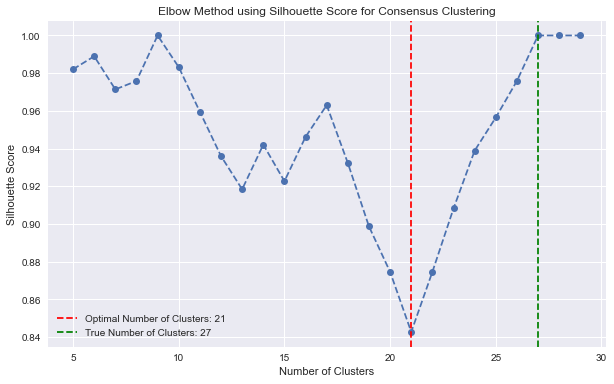

In [15]:
optimal_number_of_clusters = get_optimal_clusters_plot(clusters_dict=clusters_dict,
                                                       clusters_possible_range=clusters_possible_range,
                                                       silhouette_scores=silhouette_scores)

Let's build co-ocurrence matrix plot for this number of clusters. We use 10,000 draws to get the co-ocurrence matrix. We see that the algorithm has detected 8 clear clusters, and other clusters are considered to be noise. 

The reason for that could be that there is a significant difference between different volatility and seasonality regimes, but different time-trend regimes do not contribute so much to the data and they are considered similar.

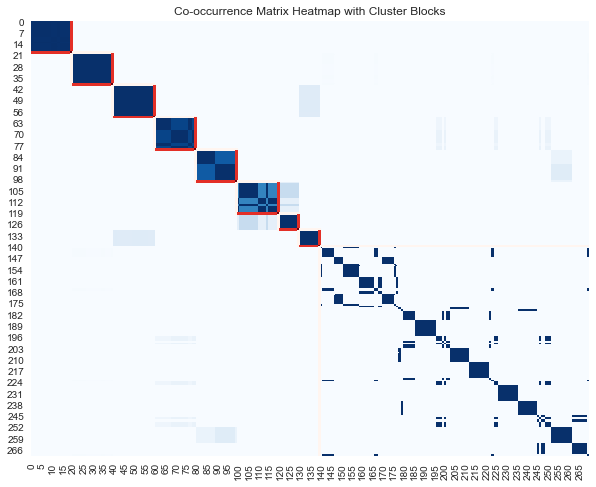

In [16]:
consensus_labels_cooccurrence = get_coocurrence_matrix_plot(dtw_matrix=dtw_matrix,
                                                            optimal_number_of_clusters=optimal_number_of_clusters,
                                                            n_runs=10000)

We can look at distribution of sectors across the stocks

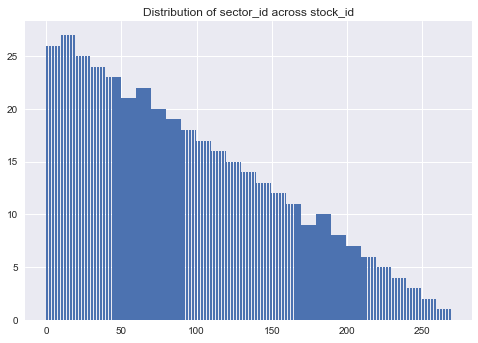

In [18]:
df_sectors_map = get_sectors(consensus_labels=consensus_labels)

plt.bar(df_sectors_map.stock_id,
        df_sectors_map.sector_id)
plt.title('Distribution of sector_id across stock_id')
plt.show()

In [24]:
df_sectors_map[df_sectors_map.sector_id == 1]

,stock_id,sector_id
260,260,1
261,261,1
262,262,1
263,263,1
264,264,1
265,265,1
266,266,1
267,267,1
268,268,1
269,269,1


If we use denoised optimal number of clusters, we get the following bar chart

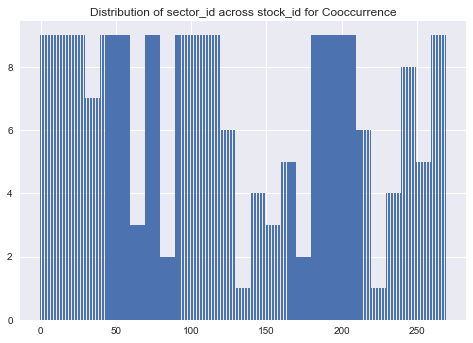

In [25]:
df_sectors_map_cooccurrence = get_sectors(consensus_labels=consensus_labels_cooccurrence)

plt.bar(df_sectors_map_cooccurrence.stock_id,
        df_sectors_map_cooccurrence.sector_id)
plt.title('Distribution of sector_id across stock_id for Cooccurrence')
plt.show()

In [26]:
df_sectors_map_cooccurrence[df_sectors_map_cooccurrence.sector_id == 1]

,stock_id,sector_id
130,130,1
131,131,1
132,132,1
133,133,1
134,134,1
135,135,1
136,136,1
137,137,1
138,138,1
139,139,1


### Applications

We could use generated clusters to get remove sector effect from asset returns to do further inference on processed data.

In this case, we would setup the following OLS framework

$$r_{S_i} = \beta_{i, 0} + \beta_{i, 1} \text{Sector}_{S_i} + \beta_{i, 2} \text{Index} + \varepsilon_i$$

After checking the OLS assumptions and adjusting our regression process, we would work with residuals $\varepsilon_i$:

### OLS Assumptions, Identifications, and Solutions
---
#### Linearity in Parameters
- **Identification**: Residuals against fitted values plot. A non-random pattern suggests non-linearity.
- **Solution**: Transformations to the dependent and/or independent variables.

---

#### Random Sampling
- **Identification**: Experimental design issue.
- **Solution**: Ensure the sample is randomly drawn.

---

#### No Perfect Collinearity
- **Identification**: Check the condition number/Variance-Inflation-Factor (VIF). A high value indicates multicollinearity.
- **Solution**: Remove or combine collinear variables. Reduce dimensionality.

---

#### Zero Conditional Mean
- **Identification**: Plot residuals against independent variables. Should be centered around zero.
- **Solution**: Include relevant variables that may be causing the bias. Consider using instrumental variables.

---

#### Homoscedasticity
- **Identification**: Plot squared residuals against fitted values or use tests like Breusch-Pagan.
- **Solution**: Transformations or use Generalized Least Squares (GLS).

---

#### No Autocorrelation
- **Identification**: Tests like Durbin-Watson or Breusch-Godfrey.
- **Solution**: Time-series models like ARIMA/VARIMA or use robust standard errors.

---

#### Normality of Residuals
- **Identification**: Tests like Jarque-Bera test.
- **Solution**: Transformations to achieve normal distribution of residuals.

---

#### Functional Form
- **Identification**: Use the Ramsey RESET test to check for omitted variable bias.
- **Solution**: Include omitted variables or non-linear transformations.

---

#### Stability of Coefficients
- **Identification**: Use the Chow test to identify structural breaks.
- **Solution**: Use rolling regression or time-series models that account for structural changes.

---

What trading strategy could we apply this approach to?

- We could use it in pairs-trading assets with different volatility
- Clusters trades for inter- and intra-asset classes
- Trading assets with heterogenous price sampling: liquid vs illiquid instruments

### Further Improvements

There are several improvements we could do in this implementation:

**Data Generation**
- Improve GBM discretization error using different discretization method. Equidistant Euler-Maruyama scheme converges strongly to the sample Brownian Motion path with an order $\frac{1}{2}$. We could  do better and apply Ito's Lemma to get Millstein discretization, which would converge strongly to the sample path with order 1
- Check different sampling frequency of data to see how does result change. For example, we could see the effect of microstructure noise on the estimations

**Computation**
- Improve computation speed using multithreading framework for DTW matrix, Silhouette scores, and Co-Occurrence matrix calculations

**General Approach**
- Include time-series of different lengths to get a more realistic example of heterogeneous time-series

### References

- Neubauer, Lukas and Filzmoser, Peter. (2023). "Improving Forecasts for Heterogeneous Time Series by 'Averaging', with Application to Food Demand Forecast". [arXiv Preprint](https://arxiv.org/pdf/2306.07119.pdf)